In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import time
from catboost import Pool
from catboost import CatBoostRegressor
from omegaconf import OmegaConf
from scipy.stats import norm
from nba_ingame_prob.consts import proj_paths
from nba_ingame_prob.model.inputs import prepare_scalers
from nba_ingame_prob.training.catboost import data_pipeline_cb
from nba_ingame_prob.training.pipeline import prepare_data

In [12]:
now = time.strftime("%Y%m%d-%H%M%S")
config = OmegaConf.load(proj_paths.config.catboost)
scalers_path = proj_paths.output / f'scalers-{now}-cat.pkl'
input_teams = config['inputs_team'] or []
data_prepared = prepare_data(**config.data_params)
scalers = prepare_scalers(data_prepared.X_train, input_teams, scalers_path)


In [13]:
unify_home_away = config.training.model_config.get('unify_home_away', False)
include_teams = config.training.model_config.get('include_teams', False)
X_train, y_train = data_pipeline_cb(data_prepared.X_train, scalers, input_teams, include_teams, config['target'], unify_home_away)
X_test, y_test = data_pipeline_cb(data_prepared.X_test, scalers, input_teams, include_teams, config['target'], unify_home_away, drop_game_id=False)
if include_teams:
    if unify_home_away:
        cat_features = ['team', 'team_opponent']
    else:
        cat_features = ['home_team', 'away_team']
else:
    cat_features = []

train_dir = proj_paths.output / 'catboost' / now
train_dir.mkdir(parents=True, exist_ok=True)

pool_train = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)
pool_test = Pool(
    data=X_test.drop(columns=['game_id']),
    label=y_test,
    cat_features=cat_features
)

In [17]:
model = CatBoostRegressor(**config.training.params, train_dir=train_dir)
report = model.fit(pool_train, eval_set=pool_test, verbose=100)

0:	learn: -0.0277518	test: -0.0312207	best: -0.0312207 (0)	total: 62.2ms	remaining: 2m 4s
100:	learn: -0.3137038	test: -0.3011519	best: -0.3011519 (100)	total: 1.57s	remaining: 29.6s
200:	learn: -0.4230514	test: -0.3940359	best: -0.3940359 (200)	total: 2.76s	remaining: 24.7s
300:	learn: -0.4864600	test: -0.4419588	best: -0.4419588 (300)	total: 3.93s	remaining: 22.2s
400:	learn: -0.5316272	test: -0.4737200	best: -0.4737200 (400)	total: 5.22s	remaining: 20.8s
500:	learn: -0.5727876	test: -0.4849035	best: -0.4853036 (488)	total: 6.46s	remaining: 19.3s
600:	learn: -0.6071891	test: -0.4718516	best: -0.4853036 (488)	total: 7.79s	remaining: 18.1s
700:	learn: -0.6291452	test: -0.4493820	best: -0.4853036 (488)	total: 8.97s	remaining: 16.6s
800:	learn: -0.6472846	test: -0.4291947	best: -0.4853036 (488)	total: 10.3s	remaining: 15.4s
900:	learn: -0.6656166	test: -0.4059666	best: -0.4853036 (488)	total: 11.7s	remaining: 14.3s
1000:	learn: -0.6844628	test: -0.3777853	best: -0.4853036 (488)	total: 13

In [19]:
y_true_train = y_train['final_score_diff'] > 0.5
preds = model.predict(X_train)
mean, _ = preds[:,0], preds[:,1]
y_pred_train = mean > 0.5
accuracy_train = np.mean(y_true_train == y_pred_train)
print(f'Train accuracy: {accuracy_train}')

Train accuracy: 0.7922570016474465


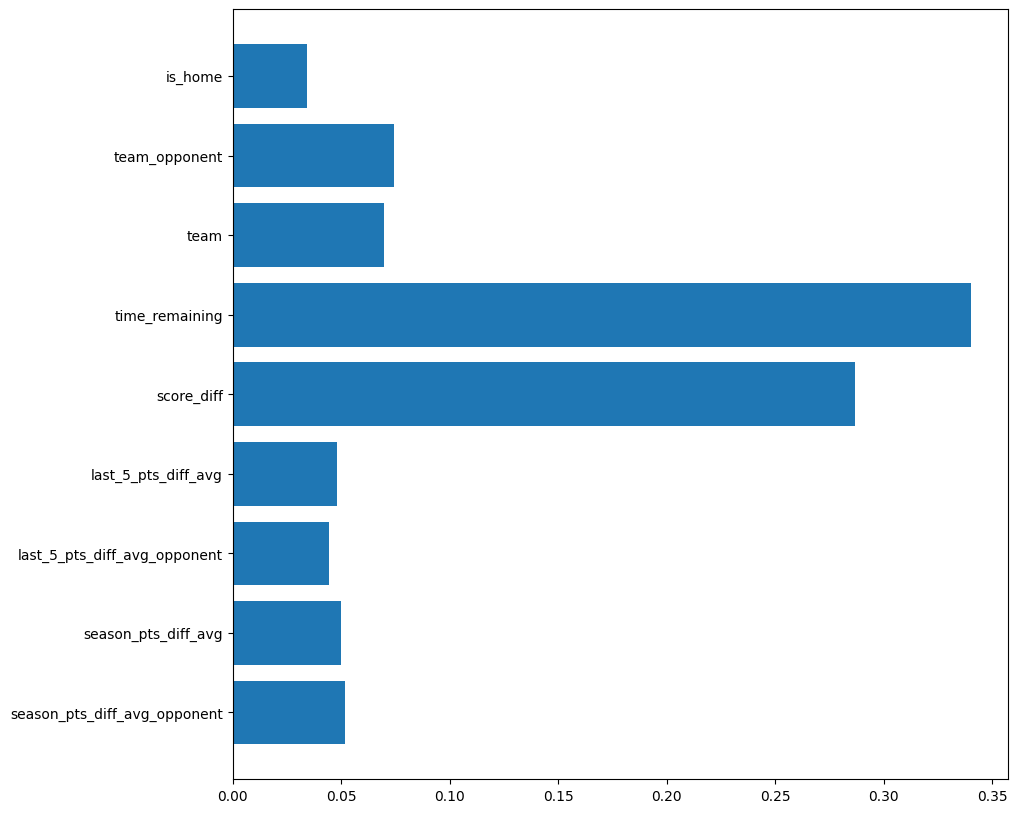

In [20]:
feature_importance = model.get_feature_importance()
feature_importance = feature_importance / feature_importance.sum()
feature_importance = pd.Series(feature_importance, index=X_train.columns)
feature_importance.sort_values(ascending=False) * 100

plt.figure(figsize=(10, 10))
plt.barh(feature_importance.index, feature_importance)
plt.show()

In [114]:
from scoringrules import crps_tnormal


pool = Pool(
    data=X_test.drop(columns=['game_id']),
    cat_features=cat_features
)
X_test['final_score_diff'] = y_test['final_score_diff']
preds = model.predict(pool)
mean, var_preds = preds[:,0], preds[:,1]
std = np.sqrt(var_preds)
prob = norm.cdf(0, mean - 0.5, std)

if unify_home_away:
    data = X_test[:len(prob)//2].copy()
data['mean'] = mean[:len(data)] if unify_home_away else mean
data['std'] = std[:len(data)] if unify_home_away else std
data['prob'] = prob[:len(data)] if unify_home_away else prob
data['cprs'] = pd.Series([
    crps_tnormal(y, m, s, lower=0, upper=1)
    for y, m, s in zip(data['final_score_diff'], data['mean'], data['std'])
])
data['abs_err'] = np.abs(data['final_score_diff'] - data['mean'])

if unify_home_away:
    data['mean_away'] = mean[len(data):]
    data['std_away'] = std[len(data):]
    data['prob_away'] = prob[len(data):]
    data['cprs_away'] = pd.Series([
        crps_tnormal(y, m, s, lower=0, upper=1)
        for y, m, s in zip(data['final_score_diff'], 1 - data['mean_away'], data['std_away'])
    ])
    data['abs_err_away'] = np.abs(data['final_score_diff'] - (1 - data['mean_away']))

In [113]:
prob2 = norm.cdf(0, (mean - 0.5)*4, std*4)

In [55]:
yth = y_test[len(y_test)//2:]['final_score_diff']
yta = y_test[:len(y_test)//2]['final_score_diff']

In [57]:
(yth - 1 + yta).mean()

-2.135044278125301e-18

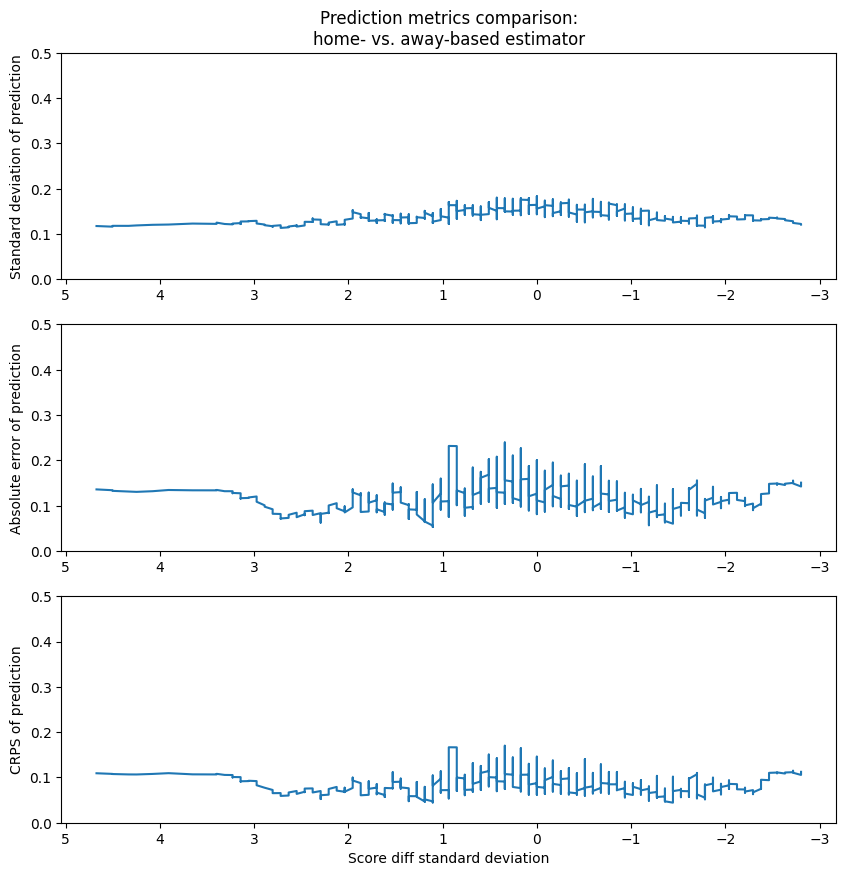

{'precision': 0.046794871794871795,
 'mean_std': 0.14924561336454234,
 'mean_abs_err': 0.12671081341841073,
 'mean_crps': 0.09000622740764652}

In [ ]:
from nba_ingame_prob.consts import game_info


def get_comparison_plot(data: pd.DataFrame, index_col: str = 'time_remaining', smooting_window: int=10, plot_away: bool=False):
    data_sorted = data.sort_values(index_col).reset_index(drop=True)
    data_sorted['time_remaining'] = (data_sorted['time_remaining'] + 1)/2*game_info.match_time
    fig, ax = plt.subplots(3, 1, figsize=(10, 10))

    ax[0].set_title('Prediction metrics' + (' comparison:\nhome- vs. away-based estimator' if unify_home_away else ''))
    label_std = 'std' if not unify_home_away else 'std_home'
    ax[0].plot(data_sorted[index_col], data_sorted['std'].rolling(smooting_window).mean(), label=label_std)
    if plot_away:
        ax[0].plot(data_sorted[index_col], data_sorted['std_away'].rolling(smooting_window).mean(), label='std_away')
        ax[0].legend()
    ylim = 0.5 if data_sorted['std'].max() < 0.5 else 1.0
    ax[0].set_ylim(0, ylim)
    ax[0].set_ylabel('Standard deviation of prediction')
    ax[0].invert_xaxis()

    label_abs_err = 'abs_err' if not unify_home_away else 'abs_err_home'
    ax[1].plot(data_sorted[index_col], data_sorted['abs_err'].rolling(smooting_window).mean(), label=label_abs_err)
    if plot_away:
        ax[1].plot(data_sorted[index_col], data_sorted['abs_err_away'].rolling(smooting_window).mean(), label='abs_err_away')
        ax[1].legend()
    ylim = 0.5 if data_sorted['abs_err'].rolling(smooting_window).mean().max() < 0.5 else 1.0
    ax[1].set_ylim(0, ylim)
    ax[1].set_ylabel('Absolute error of prediction')
    ax[1].invert_xaxis()

    label_crps = 'cprs' if not unify_home_away else 'cprs_home'
    ax[2].plot(data_sorted[index_col], data_sorted['cprs'].rolling(smooting_window).mean(), label=label_crps)
    if plot_away:
        ax[2].plot(data_sorted[index_col], data_sorted['cprs_away'].rolling(smooting_window).mean(), label='cprs_away')
        ax[2].legend()
    ylim = 0.5 if data_sorted['cprs'].rolling(smooting_window).mean().max() < 0.5 else 1.0
    ax[2].set_ylim(0, ylim)
    ax[2].set_xlabel(index_col.capitalize().replace('_', ' '))
    ax[2].set_ylabel('CRPS of prediction')
    ax[2].invert_xaxis()

    return fig, ax

def get_metrics(data: pd.DataFrame, draw_score_diff: float):
    metrics = {
        'precision': ((data['prob'] > draw_score_diff)*(data['final_score_diff'] > draw_score_diff)).mean(),
        'mean_std': data['std'].mean(),
        'mean_abs_err': data['abs_err'].mean(),
        'mean_crps': data['cprs'].mean()
    }
    return metrics

fig, ax = get_comparison_plot(data, plot_away=False, index_col='score_diff', smooting_window=20)
ax[-1].set_xlabel('Score diff standard deviation')
plt.show()

metrics = get_metrics(data, draw_score_diff=0.5)
metrics

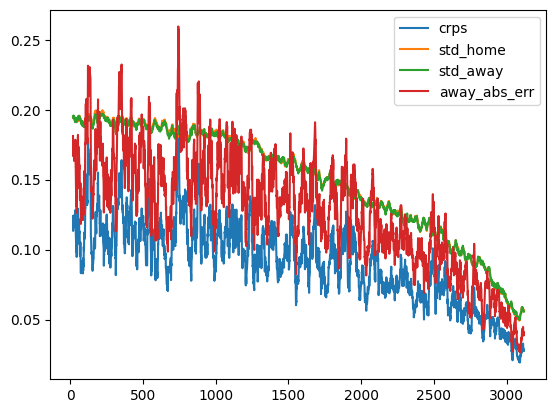

In [ ]:
sorted_data = data.sort_values('time_remaining', ascending=False).reset_index()
sorted_data['crps'].rolling(20).mean().plot()
sorted_data['std_home'].rolling(20).mean().plot()
sorted_data['std_away'].rolling(20).mean().plot()
sorted_data['home_abs_err'].rolling(20).mean().plot()
sorted_data['away_abs_err'].rolling(20).mean().plot()
#sorted_data['']
plt.legend()
plt.show()

In [43]:
data

,season_pts_diff_avg_opponent,season_pts_diff_avg,last_5_pts_diff_avg_opponent,last_5_pts_diff_avg,score_diff,time_remaining,game_id,team,team_opponent,is_home,mean_home,std_home,prob_home,mean_away,std_away,prob_away,crps
105,-0.615404,1.213408,-1.058354,1.355456,0.169913,0.990278,0022401224,CLE,BKN,True,0.394998,0.190365,0.709383,0.601111,0.190391,0.297684,0.272321
3045,-0.416958,-1.597148,0.748071,-0.182151,0.169913,0.989583,0022400557,NOP,CHI,True,0.538296,0.188978,0.419704,0.444867,0.188004,0.615337,0.080523
1455,-0.917092,-0.591155,-1.082439,-0.962782,-0.169913,0.988889,0022400442,CHI,CHA,True,0.446522,0.190009,0.610818,0.556611,0.193255,0.384787,0.051807
2235,1.121817,0.665239,-0.528469,-0.678916,-0.169913,0.985417,0022400499,DAL,MEM,True,0.483367,0.203303,0.532603,0.516089,0.199629,0.467882,0.164645
2820,0.684883,0.471096,-0.215356,0.882346,0.169913,0.985417,0022400540,DEN,DAL,True,0.516031,0.208834,0.469406,0.475064,0.209958,0.547270,0.115646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,-0.877179,-0.845106,0.314529,-1.104715,0.849566,-1.000000,0022400373,CHA,PHI,True,0.651355,0.054333,0.002671,0.346714,0.050228,0.998863,0.013574
3014,0.239035,0.224935,-1.226953,0.007093,0.934522,-1.000000,0022400553,MIA,LAC,True,0.646908,0.052483,0.002562,0.348777,0.051839,0.998234,0.019644
764,-0.796080,-0.259022,0.579471,-0.324084,-0.254870,-1.000000,0022400404,DET,LAL,True,0.502524,0.049779,0.479784,0.502487,0.052878,0.481244,0.030978
749,0.504499,1.763884,-0.143099,1.118901,0.339826,-1.000000,0022400393,BOS,ORL,True,0.516654,0.053746,0.378331,0.479634,0.052167,0.651882,0.028777


In [27]:
y_true_test = y_test['final_score_diff'] > 0.5
y_pred_test = mean > 0.5
accuracy_test = np.mean(y_true_test == y_pred_test)
print(f'Test accuracy: {accuracy_test}')

probs = pd.Series(prob, index=X_test.time_remaining)
plt.figure(figsize=(10, 10))
# plt.scatter(probs, y_test)
probs_time = probs.sort_index()
y = pd.Series(y_test.final_score_diff > 0, index=X_test.time_remaining).sort_index()
plt.scatter(probs_time.index, probs_time)#, c=y)

Test accuracy: 0.7333333333333333


ValueError: cannot reindex on an axis with duplicate labels

<Figure size 1000x1000 with 0 Axes>

In [15]:
config_path = proj_paths.models / f'run_config-{now}-cat.yaml'
config_path.open("w").write(OmegaConf.to_yaml(config))
model_path = proj_paths.models / f'cb_model-{now}-cat.cbm'
model.save_model(model_path)
shutil.copyfile(scalers_path, proj_paths.models / f'scalers-{now}-cat.pkl')
print(model_path)

/workspaces/nba-ingame-prob/models/cb_model-20250212-163502-cat.cbm
